In [1]:
%load_ext autoreload
%autoreload 2

import anndata as ad
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
from mmd_wrapper.utilities import alignment_visualize, pairwise_error
import numpy as np
import pandas as pd

from commando import ComManDo

2021-10-16 20:30:01.066152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-16 20:30:01.066189: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


# Read Data

In [2]:
# X1 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod1.h5ad')
# X2 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.mod2.h5ad')
data_mod1 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_phase1/openproblems_bmmc_multiome_phase1.censor_dataset.output_mod1.h5ad')
data_mod2 = ad.read_h5ad('OPSCA/openproblems_bmmc_multiome_phase1/openproblems_bmmc_multiome_phase1.censor_dataset.output_mod2.h5ad')

In [3]:
# Euclidean w/ defaults
# CPU (4x longer assuming linear)
# cells  features   algo_time (s)
# 500    ALL        34

# GPU
# Closest fit .0000015*(# of cells)^2.43
# For 22k cells, ~14.8 hours
# cells  features   algo_time (s)
# 2k     50         119
# 2k     100        120
# -------------------------------
# 500    ALL        8
# 1k     ALL        23
# 2k     ALL        158
# 4k     ALL        852

# from commando.utilities import reduce_sample_data
# X1 = reduce_sample_data(data_mod1.X)[:500]
# X2 = reduce_sample_data(data_mod2.X)[:500]
X1 = data_mod1.X[:500]
X2 = data_mod2.X[:500]

# Run Mapping

In [4]:
commando_out = (
    ComManDo(
        distance_mode='euclidean',
        gradient_reduction=100,
        gradient_reduction_threshold=.99,
        epoch_pd=2000,
        log_pd=100,
    )
    .fit_transform([X1, X2])
)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 13431)
Dataset 1: (500, 116490)
---------------------------------
Find correspondence between Dataset 1 and Dataset 1
use device: cpu
epoch:[100/2000] err:13.7192 alpha:1.8330
epoch:[200/2000] err:1.8543 alpha:0.2470
epoch:[300/2000] err:0.2782 alpha:0.0359
epoch:[400/2000] err:0.0629 alpha:0.0086
epoch:[500/2000] err:0.0275 alpha:0.0103
epoch:[600/2000] err:0.0260 alpha:0.0112
epoch:[700/2000] err:0.0310 alpha:0.0124
epoch:[800/2000] err:0.0389 alpha:0.0153
epoch:[900/2000] err:0.0422 alpha:0.0164
epoch:[1000/2000] err:0.0412 alpha:0.0173
epoch:[1100/2000] err:0.0452 alpha:0.0197
epoch:[1200/2000] err:0.0461 alpha:0.0210
epoch:[1300/2000] err:0.0506 alpha:0.0247
epoch:[1400/2000] err:0.0515 alpha:0.0253
epoch:[1500/2000] err:0.0542 alpha:0.0287
epoch:[1600/2000] err:0.0552 alpha:0.0303
epoch:[1700/2000] err:0.0554 alpha:0.0313
epoch:[1800/2000] err:0.0614 alpha:0.0350
epoch:[1900/2000] err:0.0573 alpha:0.0339
epoch:[2000/2000] er

# Compare

In [5]:
# NMAcom
print('NMAcom Pairwise Error: ' + str(pairwise_error(*commando_out, normalize_by_feature=True)))
print()

# Create dense data
densify = lambda df: np.array(df.todense())
X1_dense = densify(X1)
X2_dense = densify(X2)

# UnionCom
unioncom_out = mmd_combine(X1_dense, X2_dense, method='unioncom', verbose=0)
print('UnionCom Pairwise Error: ' + str(pairwise_error(*unioncom_out[0], normalize_by_feature=True)))
print()

# ManiNetCluster
maninetcluster_out = mmd_combine(X1_dense, X2_dense,
                                 method='maninetcluster',
                                 alignment='nonlinear manifold aln',
                                 num_dims=2)
print('ManiNetCluster Pairwise Error: ' + str(pairwise_error(*maninetcluster_out[0], normalize_by_feature=True)))

NMAcom Pairwise Error: 1.101568164416591

UnionCom Pairwise Error: 26.014182452112436

ManiNetCluster Pairwise Error: 16.94861821868187


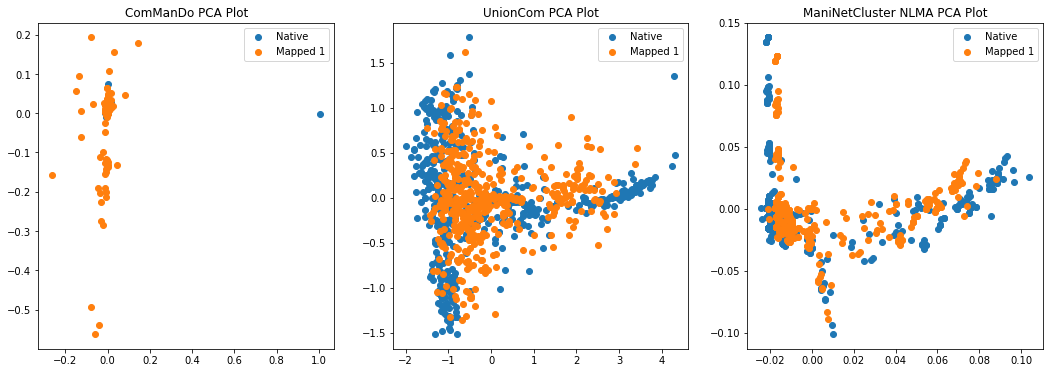

In [6]:
mappings = [commando_out, unioncom_out[0], maninetcluster_out[0]]
names = ['ComManDo', 'UnionCom', 'ManiNetCluster NLMA']

plt.subplots(figsize=(6*len(names), 6))
for i, mapping in enumerate(mappings):
    plt.subplot(1, len(names), i+1)
    alignment_visualize(*mapping, alg_name=names[i])

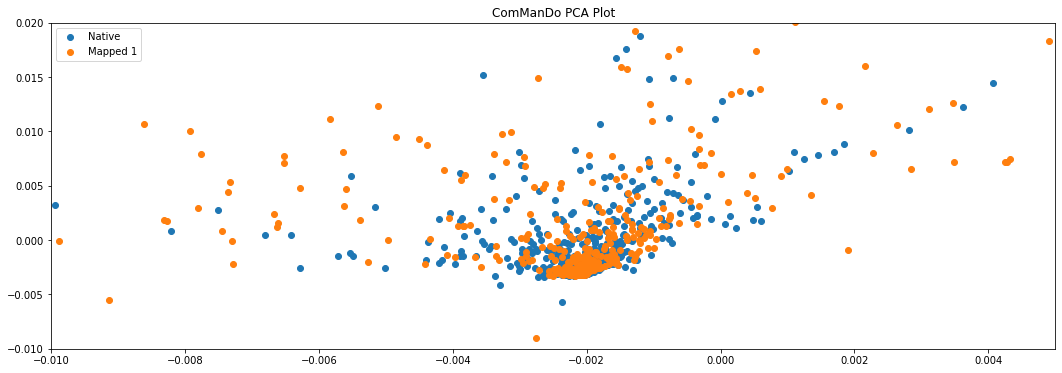

In [12]:
plt.subplots(figsize=(6*len(names), 6))
plt.axis([-.01, .005, -.01, .02])
alignment_visualize(*commando_out, alg_name='ComManDo')